In [110]:
## import libraries
import numpy as np
import pandas as pd
import calendar
from numpy import percentile
import math
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import itertools
import collections

from sklearn.model_selection import cross_val_score , train_test_split
from sklearn.metrics import mean_squared_error, r2_score , classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler , Imputer
from sklearn.model_selection import GridSearchCV , ShuffleSplit
from sklearn.ensemble import RandomForestRegressor , GradientBoostingClassifier, LogisticRegression, KNeighborsClassifier,DecisionTreeClassifier 


from sklearn import metrics
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek
from sklearn.metrics import roc_curve , auc



from sklearn.datasets import make_classification
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from matplotlib import pyplot

%matplotlib inline

In [2]:
# read review, listing and calendar data
data_review = pd.read_csv('C:/Users/rahil.bagheri/OneDrive - REI Systems Inc/Desktop/Airbnb/reviews.csv')
data_listing = pd.read_csv('C:/Users/rahil.bagheri/OneDrive - REI Systems Inc/Desktop/Airbnb/listings.csv')
data_calendar = pd.read_csv('C:/Users/rahil.bagheri/OneDrive - REI Systems Inc/Desktop/Airbnb/calendar.csv')

In [3]:
# a function that formats variables like price,rates, dates
def cleaned_data(data):
    
    # Convert string of prices to floats
    
    data['price_y'] = data['price_y'].astype(str).str.replace('$','')
    data['price_y'] = data['price_y'].astype(str).str.replace(',','')
    data['price_y'] = data['price_y'].astype(float)
    
    data['weekly_price'] = data['weekly_price'].astype(str).str.replace('$','')
    data['weekly_price'] = data['weekly_price'].astype(str).str.replace(',','')
    data['weekly_price'] = data['weekly_price'].astype(float)
    
    data['monthly_price'] = data['monthly_price'].astype(str).str.replace('$','')
    data['monthly_price'] = data['monthly_price'].astype(str).str.replace(',','')
    data['monthly_price'] = data['monthly_price'].astype(float)
    
    data['extra_people'] = data['extra_people'].astype(str).str.replace('$','')
    data['extra_people'] = data['extra_people'].astype(str).str.replace(',','')
    data['extra_people'] = data['extra_people'].astype(str).astype(float)
    
    data['cleaning_fee'] = data['cleaning_fee'].astype(str).str.replace('$','')
    data['cleaning_fee'] = data['cleaning_fee'].astype(str).str.replace(',','')
    data['cleaning_fee'] = data['cleaning_fee'].astype(str).astype(float)
    
    data['security_deposit'] = data['security_deposit'].astype(str).str.replace('$','')
    data['security_deposit'] = data['security_deposit'].astype(str).str.replace(',','')
    data['security_deposit'] = data['security_deposit'].astype(float)
    
    
    data['host_acceptance_rate'] = data['host_acceptance_rate'].astype(str).str.replace('%','')
    data['host_acceptance_rate'] = data['host_acceptance_rate'].astype(float)
    
    data['host_response_rate'] = data['host_response_rate'].astype(str).str.replace('%','')
    data['host_response_rate'] = data['host_response_rate'].astype(float)
    
    data['date'] = pd.to_datetime(data['date'])
    data['host_since'] = pd.to_datetime(data['host_since'])

    data['month']=data.date.dt.month
    data['year']=data.host_since.dt.year

  
    return data

In [188]:
# merge listing and calendar data sets to find correlation between price and other features
data_listing = data_listing.rename(columns={'id' : 'listing_id'})
data_new = data_listing.merge(data_calendar , on ='listing_id')
Data_Revenue = cleaned_data(data_new)


In [189]:
# drop the rows having zero prices
Data_Revenue.dropna(axis=0,subset=['price_y'],inplace=True)

# merge data revenue and review and clean it
Data_Revenue = Data_Revenue.merge(data_review, on ='listing_id')
Data_Revenue = cleaned_data(data_new)

In [209]:
# how many rows and columns
Data_Revenue.shape

(934542, 97)

In [210]:
# select important variables I think might be Correlated to price 
colmns =['listing_id','property_type', 'room_type','bathrooms', 'bedrooms','accommodates','beds','year',\
                                     'host_is_superhost','availability_365','availability_30','availability_60',\
                                     'availability_90','number_of_reviews','price_y','bed_type',\
                                     'require_guest_phone_verification','cancellation_policy','require_guest_profile_picture',\
                                     'review_scores_value','review_scores_rating',\
                                     'review_scores_cleanliness','review_scores_communication','minimum_nights','guests_included',\
                                     'cleaning_fee','host_response_rate','host_response_time','host_acceptance_rate',\
                                     'instant_bookable', 'host_total_listings_count',\
                                     'neighbourhood_cleansed','extra_people','reviews_per_month','available','review_scores_accuracy','security_deposit']

Data_Revenue = Data_Revenue[colmns]

# since I selected the important variables, it is time to remove duplicates 
Data_Revenue = Data_Revenue.drop_duplicates()
Data_Revenue.dropna(axis=0,subset=['price_y'],inplace=True)

In [211]:
Data_Revenue.head()

,listing_id,property_type,room_type,bathrooms,bedrooms,accommodates,beds,year,host_is_superhost,availability_365,...,host_response_time,host_acceptance_rate,instant_bookable,host_total_listings_count,neighbourhood_cleansed,extra_people,reviews_per_month,available,review_scores_accuracy,security_deposit
0,241032,Apartment,Entire home/apt,1.0,1.0,4,1.0,2011.0,f,346,...,within a few hours,100.0,f,3.0,West Queen Anne,5.0,4.07,t,10.0,NaN
365,953595,Apartment,Entire home/apt,1.0,1.0,4,1.0,2013.0,t,291,...,within an hour,100.0,f,6.0,West Queen Anne,0.0,1.48,t,10.0,100.0
452,953595,Apartment,Entire home/apt,1.0,1.0,4,1.0,2013.0,t,291,...,within an hour,100.0,f,6.0,West Queen Anne,0.0,1.48,t,10.0,100.0
453,953595,Apartment,Entire home/apt,1.0,1.0,4,1.0,2013.0,t,291,...,within an hour,100.0,f,6.0,West Queen Anne,0.0,1.48,t,10.0,100.0
454,953595,Apartment,Entire home/apt,1.0,1.0,4,1.0,2013.0,t,291,...,within an hour,100.0,f,6.0,West Queen Anne,0.0,1.48,t,10.0,100.0


In [212]:
### number of reviews review 2015: have to remove it at this study since couldnt find any correlation. But might need it in future.
#review_2015 = data_review [(data_review.date >= '2015-01-01') & (data_review.date < '2016-01-01')]   
#data_count_review_2015 = review_2015.groupby(['listing_id']).agg({'listing_id':'count'})
#data_count_review_2015.rename(index=str, columns={"listing_id": "reviews_2015"},inplace=True)
#data_count_review_2015['listing_id'] = data_count_review_2015.index.astype('int64')
#data_count_review_2015.set_index('listing_id', inplace=True)

## find average price for each listing 
data_price = Data_Revenue.groupby(['listing_id']).agg({'price_y':'mean'})
data_price.rename(index=str, columns={"listing_id": "avg_price"},inplace=True)
data_price['listing_id'] = data_price.index.astype('int64')
data_price.set_index('listing_id', inplace=True)

#data_price_review = data_price.merge(data_count_review_2015, on ='listing_id', how = 'left')

# merge the revenue data with average listing price data
Data_Revenue = Data_Revenue.merge(data_price, on ='listing_id', how = 'left')


In [213]:
Data_Revenue.head()

,listing_id,property_type,room_type,bathrooms,bedrooms,accommodates,beds,year,host_is_superhost,availability_365,...,host_acceptance_rate,instant_bookable,host_total_listings_count,neighbourhood_cleansed,extra_people,reviews_per_month,available,review_scores_accuracy,security_deposit,price_y_y
0,241032,Apartment,Entire home/apt,1.0,1.0,4,1.0,2011.0,f,346,...,100.0,f,3.0,West Queen Anne,5.0,4.07,t,10.0,NaN,85.000000
1,953595,Apartment,Entire home/apt,1.0,1.0,4,1.0,2013.0,t,291,...,100.0,f,6.0,West Queen Anne,0.0,1.48,t,10.0,100.0,182.652174
2,953595,Apartment,Entire home/apt,1.0,1.0,4,1.0,2013.0,t,291,...,100.0,f,6.0,West Queen Anne,0.0,1.48,t,10.0,100.0,182.652174
3,953595,Apartment,Entire home/apt,1.0,1.0,4,1.0,2013.0,t,291,...,100.0,f,6.0,West Queen Anne,0.0,1.48,t,10.0,100.0,182.652174
4,953595,Apartment,Entire home/apt,1.0,1.0,4,1.0,2013.0,t,291,...,100.0,f,6.0,West Queen Anne,0.0,1.48,t,10.0,100.0,182.652174


In [214]:
# drop the repeated price column and duplicats
Data_Revenue = Data_Revenue.drop(['price_y_x'], axis=1)
Data_Revenue = Data_Revenue.drop_duplicates()

# select the listings that has reviews within the current year
Data_Revenue = Data_Revenue[Data_Revenue['number_of_reviews'] <= 365]

In [215]:
Data_Revenue.shape

(3720, 37)

In [434]:
#Data_Revenue = Data_Revenue[Data_Revenue['revenue'] > 0]
#Data_Revenue.reset_index(drop=True, inplace=True)

In [216]:
# I need to define what is profitable and what is not. So, I have to come up with a metric like revenue or number of times 
# a listing was booked to measure profitability. 
# calculate revenue metric: price of each listing times the number of nigths each listing is booked.
# I assumed that the number of times each listing is booked is same as the numer of reviews each guest wrote for that listing
Data_Revenue['revenue'] = Data_Revenue['minimum_nights'] * Data_Revenue['price_y_y'] * Data_Revenue['number_of_reviews'] 
Data_Revenue = Data_Revenue[Data_Revenue['revenue'] > 0]

C:\Users\rahil.bagheri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


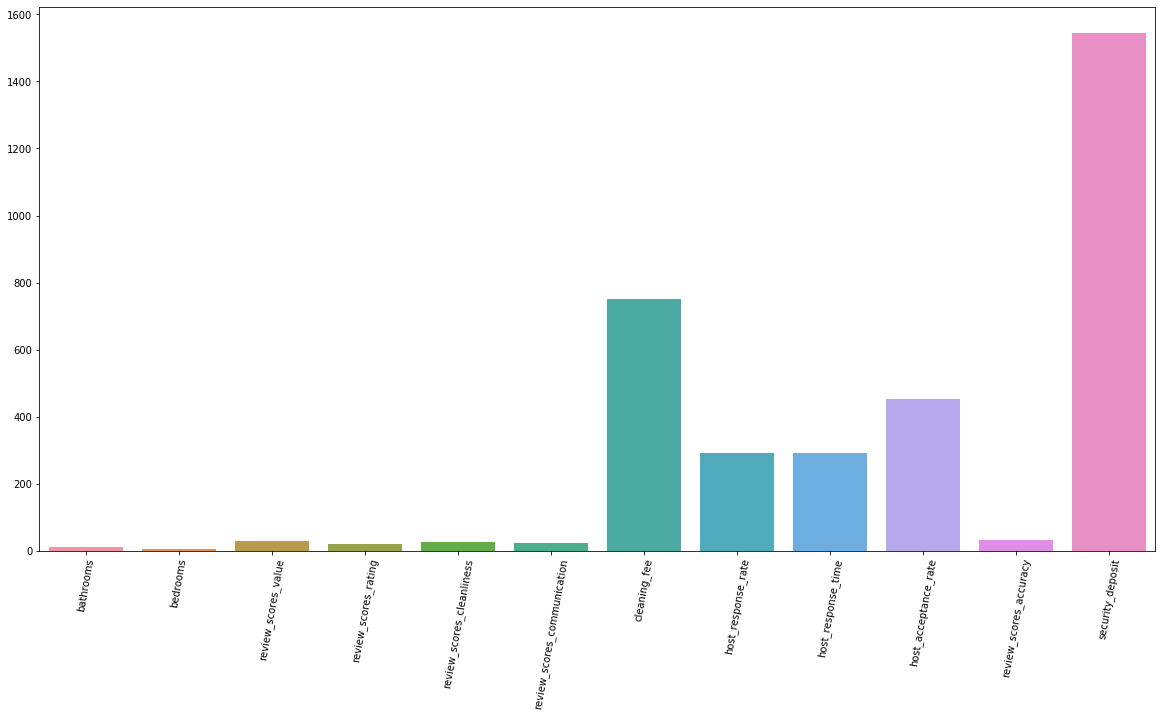

In [469]:
 ## barplot of number of missing values 
plt.figure(figsize=(20,10))
plt.xticks(rotation=80)
plt.yticks()
sns.barplot(x=Data_Revenue.isnull().sum()[Data_Revenue.isnull().sum().nonzero()[0]].index,y=Data_Revenue.isnull().sum()[Data_Revenue.isnull().sum().nonzero()[0]].values)

In [14]:
# average revenue for each unique listing ID
Listing = Data_Revenue.groupby(['listing_id'])['revenue'].mean()
Listing

listing_id
4291         5740.000000
5682        46777.500000
6606         9880.000000
7369         3400.000000
9419        13693.333333
9460        85680.000000
9531        13650.000000
9534         3500.000000
9596        11760.000000
10385        8880.000000
10695        2616.000000
11012       44415.000000
11411        5640.000000
13068       33554.756757
14386        1200.000000
15108        2520.000000
17951        3864.000000
19611        8925.090909
19619        7514.000000
19623       18399.600000
20868       24934.000000
20927       40992.000000
20928        6512.000000
23192        2289.000000
23356        4095.000000
23430        8497.500000
23919        2970.000000
24212       17193.777778
26116       44460.952381
30712       14400.000000
                ...     
9679741        82.000000
9694921       485.500000
9698202      1028.916667
9706229      2037.000000
9711153       240.000000
9712716       195.000000
9714078       356.000000
9727246        92.000000
9727857       

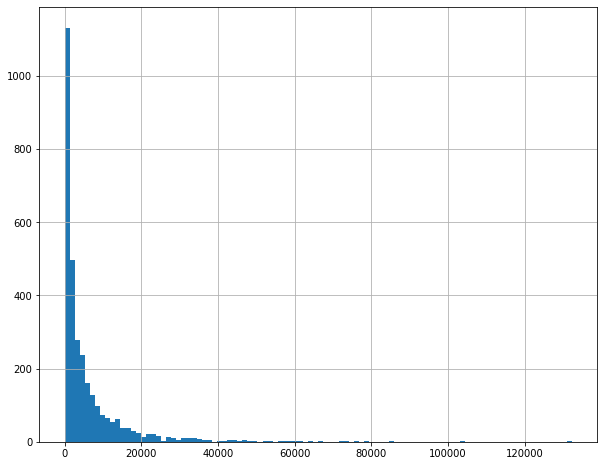

In [439]:
## how the total revenue for all the listings distributed
## how much each listing made 
Revenue_Per_Listing = Data_Revenue.groupby(['listing_id'])['revenue'].sum()
Revenue_Per_Listing = pd.DataFrame(Revenue_Per_Listing).reset_index()
Revenue_Per_Listing[Revenue_Per_Listing['revenue'] < 150000].revenue.hist(figsize=(10,8),bins=100)
## revenue is skewed to right

Text(0, 0.5, 'Price ($)')

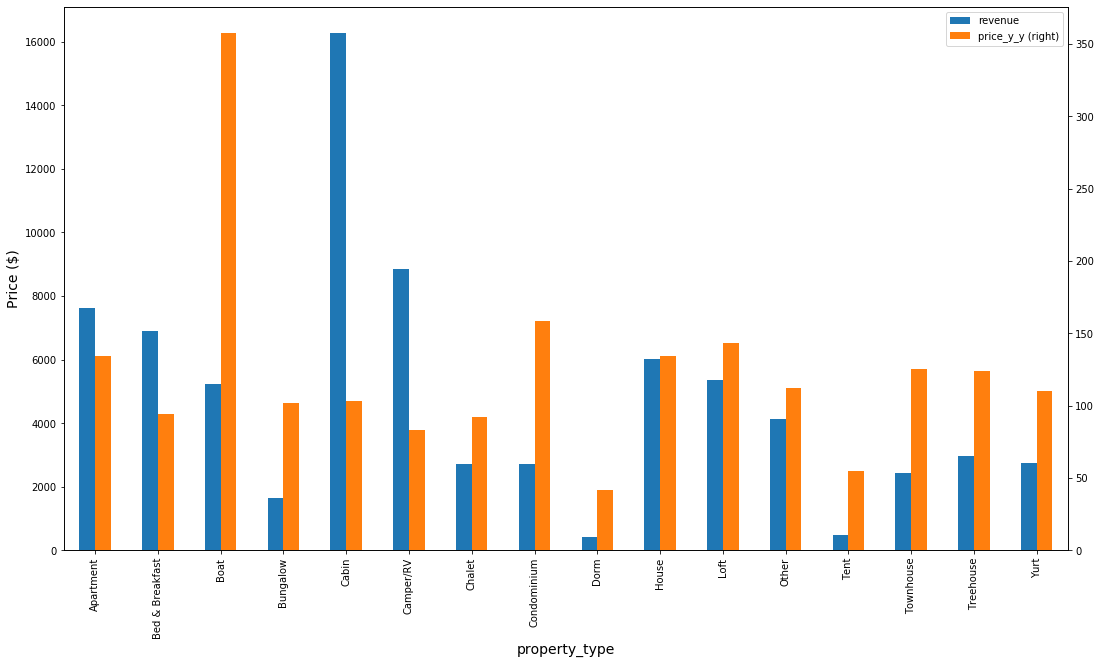

In [440]:
### plot revenue vs property and room type 
price_vs_revenue = Data_Revenue.groupby(['property_type']).agg({'revenue':'mean','price_y_y':'mean'})
#price_vs_revenue.rename(index=str, columns={"listing_id": "number_of_listings"},inplace=True)
fig, ax = plt.subplots(figsize=(18,10))
price_vs_revenue.plot.bar(y=['revenue','price_y_y'], secondary_y='price_y_y', ax=ax)
ax.set_xlabel("property_type",fontsize=14)
ax.set_ylabel("Price ($)",fontsize=14)


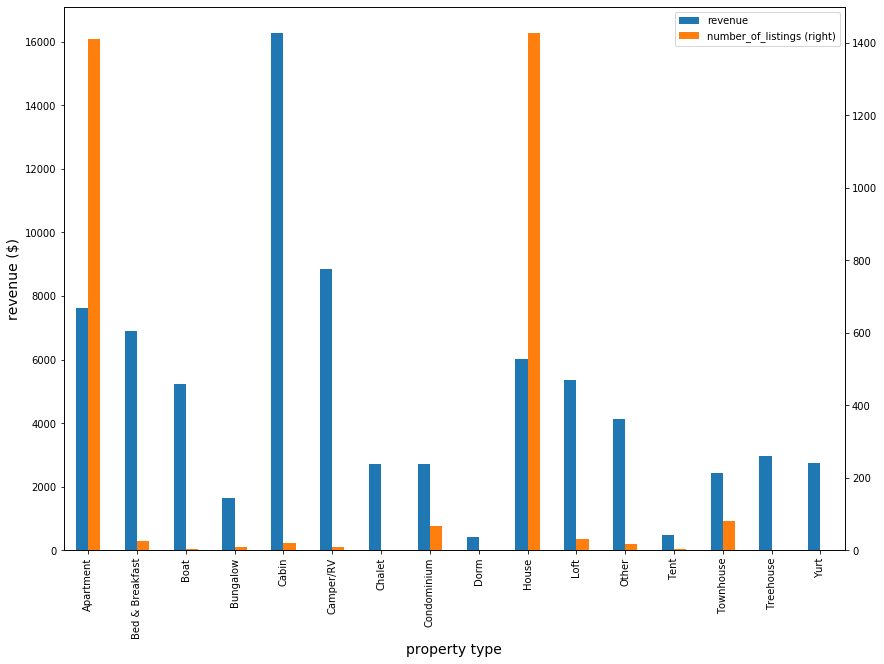

In [441]:
## property cost vs how many times those properties listed over 2016 (plot 3)
price_vs_property = Data_Revenue.groupby(['property_type']).agg({'revenue':'mean','listing_id':'count'})
price_vs_property.rename(index=str, columns={"listing_id": "number_of_listings"},inplace=True)

fig, ax = plt.subplots(figsize=(14,10))
price_vs_property.plot.bar(y=['revenue','number_of_listings'], secondary_y='number_of_listings', ax=ax)
ax.set_xlabel("property type",fontsize=14)
ax.set_ylabel("revenue ($)",fontsize=14)
fig.savefig("revenue_for_each_property.jpg", bbox_inches='tight')

In [217]:
# find the revenue quartiles. I need to find a Threshold to define if a listing is profitable or not.
Data_Revenue.revenue.describe()

count    3.118000e+03
mean     6.620010e+03
std      2.496312e+04
min      2.100000e+01
25%      7.860000e+02
50%      2.448000e+03
75%      6.936458e+03
max      1.200000e+06
Name: revenue, dtype: float64

In [220]:
# I choose 7000 to have more balanced response variable and named it performance.
# Listings with on average more than 7000 dollars revenue for 2016 are named "Top" and those that made less than 7000 are
# name "Low".
Data_Revenue['Performance'] = np.where(Data_Revenue['revenue'] >= 10000, 'Top', 'Low')

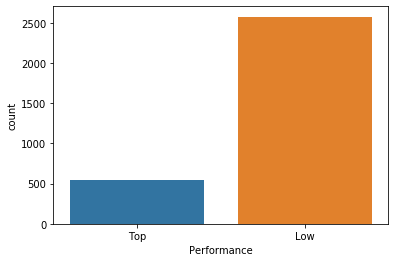

In [221]:
## performance frequancy plot
sns.countplot(x="Performance", data=Data_Revenue)

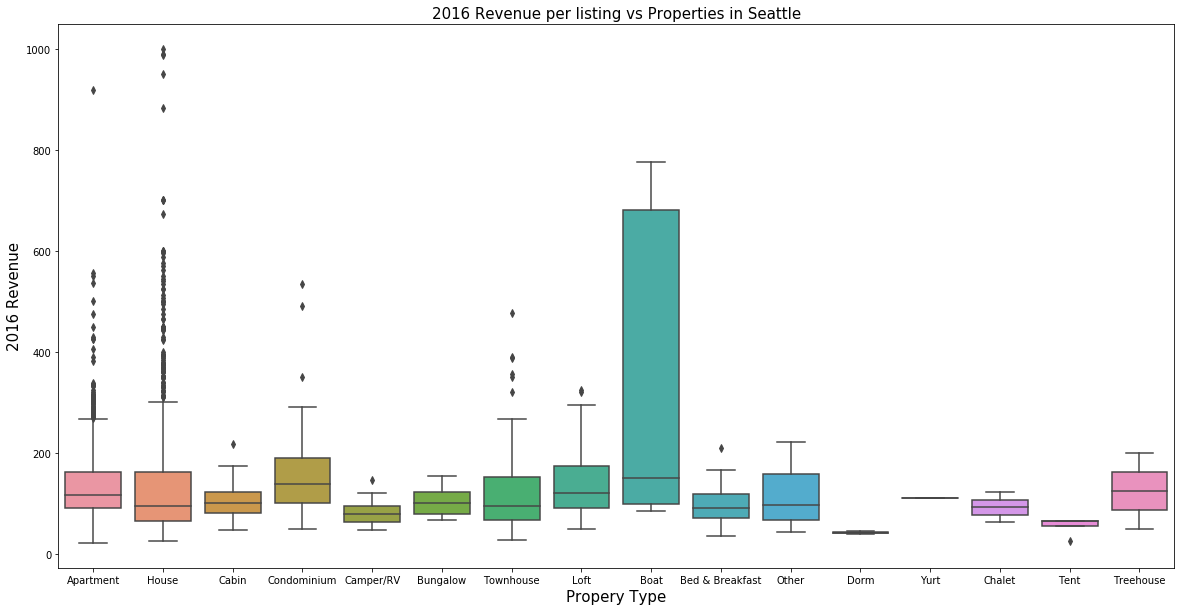

In [222]:
## barchart revenue vs property type. This plot also shows outliers for each property 
fig, ax = plt.subplots(figsize=(20,10));
bplot = sns.boxplot(x='property_type',y='price_y_y',data=Data_Revenue)
                
ax.set_title("2016 Revenue per listing vs Properties in Seattle",fontsize=15);
ax.set_xlabel("Propery Type", fontsize=15);
ax.set_ylabel("2016 Revenue", fontsize=15);


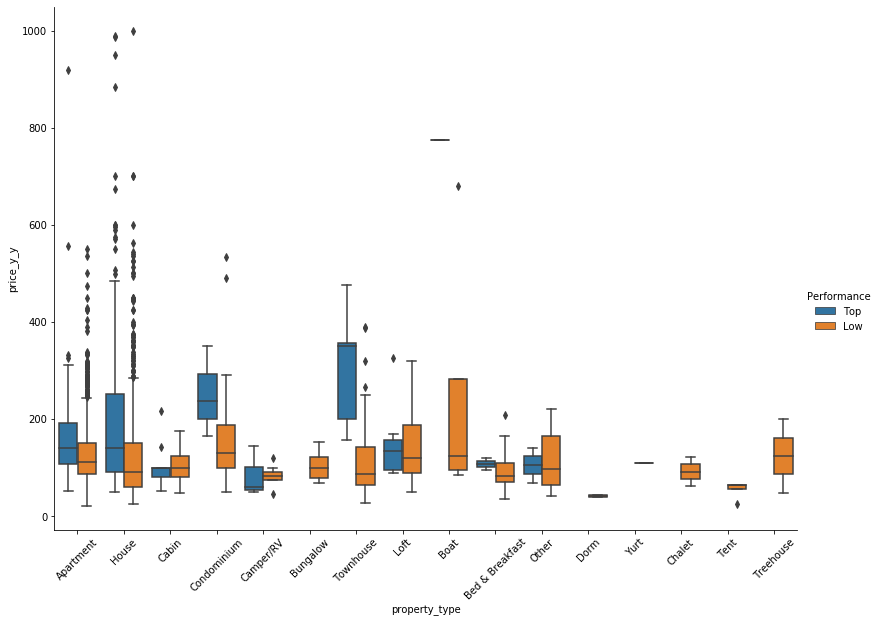

In [223]:
# bar chart property type vs price for the top and low performers
g = sns.catplot(x="property_type", y="price_y_y", hue="Performance", kind="box",height=8, aspect=11.7/8.27, data=Data_Revenue)
g.set_xticklabels(rotation=45)

In [224]:
# prepare the data for models' input by encoding and scaling

# encode binary variables that dont have missing values
binary_vars = ['require_guest_phone_verification','require_guest_profile_picture','host_is_superhost',\
                'instant_bookable','available']
for var in binary_vars:
    Data_Revenue[var] = np.where(Data_Revenue[var] == "t" ,1 , 0)
    
# encode categorical variables with more than two levels and keep the missings as a new level to data
# decided to have beds, bathrooms and bedrooms as categorical variable since we have missing values and dont want to loose 
# information but replacing them with zero or removing them 
categorical_vars = ['host_response_time', 'neighbourhood_cleansed', 'property_type', 'room_type',\
                      'bed_type', 'cancellation_policy','require_guest_phone_verification','require_guest_profile_picture',\
                      'instant_bookable','year']
for var in categorical_vars:
     Data_Revenue = pd.concat([Data_Revenue.drop(var, axis=1),\
                        pd.get_dummies(Data_Revenue[var],\
                                       prefix=var, prefix_sep='_', drop_first=False, dummy_na=True)], axis=1)
        
# replace othe missing values with the mean 
var_mean = ['bathrooms', 'bedrooms' ,'beds' ,'review_scores_value' ,'review_scores_rating','review_scores_cleanliness','cleaning_fee' ,
            'host_response_rate', 'host_acceptance_rate','review_scores_communication' ,'reviews_per_month', 'review_scores_accuracy','host_total_listings_count','security_deposit']

imputer = Imputer(strategy="mean")
Data_Revenue[var_mean] = imputer.fit_transform(Data_Revenue[var_mean])

### remove columns that has all zero values like instant bookable_nan
Data_Revenue = Data_Revenue.loc[:, (Data_Revenue != 0).any(axis=0)] 



C:\Users\rahil.bagheri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [225]:
### scale numeric variables ready for fitting
col_names = ['bathrooms','bedrooms','beds','accommodates','availability_365','availability_30','availability_60',\
             'availability_90','number_of_reviews','price_y_y','review_scores_cleanliness','minimum_nights',\
             'guests_included','host_response_rate','host_acceptance_rate','host_total_listings_count',\
             'reviews_per_month', 'extra_people','cleaning_fee','minimum_nights','review_scores_value' ,'review_scores_rating',\
             'review_scores_accuracy','review_scores_communication','security_deposit']
features = Data_Revenue[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
Data_Revenue[col_names] = features

In [226]:
Data_Revenue.head()

,listing_id,bathrooms,bedrooms,accommodates,beds,host_is_superhost,availability_365,availability_30,availability_60,availability_90,...,instant_bookable_0.0,instant_bookable_1.0,year_2008.0,year_2009.0,year_2010.0,year_2011.0,year_2012.0,year_2013.0,year_2014.0,year_2015.0
0,241032,-0.432526,-0.339351,0.319392,-0.639686,0,0.774022,-0.284978,0.122587,0.324220,...,1,0,0,0,0,1,0,0,0,0
1,953595,-0.432526,-0.339351,0.319392,-0.639686,1,0.307658,-0.369967,-1.134885,-1.390837,...,1,0,0,0,0,0,0,1,0,0
93,3308979,5.500588,4.282360,3.858002,4.588471,0,-0.294376,-1.389835,-1.449253,-1.359655,...,1,0,0,0,0,0,0,0,1,0
102,278830,1.262649,1.971505,1.330424,1.103033,0,0.935130,1.074847,0.975872,0.916694,...,1,0,0,0,0,1,0,0,0,0
106,5956968,-0.432526,-0.339351,-0.691639,-0.639686,0,0.400931,-1.474825,-1.718712,-1.047826,...,1,0,0,0,1,0,0,0,0,0


In [227]:
## remove the id and revenue. Since I created Performance column I dont need revenue feature.
Data_Revenue = Data_Revenue.drop(['listing_id','revenue','minimum_nights','price_y_y', 'number_of_reviews'], axis = 1) 

In [228]:
### remove columns that has all zero values like instant bookable_nan
Data_Revenue= Data_Revenue.loc[:, (Data_Revenue != 0).any(axis=0)] 

In [229]:
# train-valid-test split
#train, valid_test = train_test_split(Data_Revenue, test_size=0.2,random_state=1)
train, test = train_test_split(Data_Revenue, test_size=0.2,random_state=1)

Y_train = train['Performance']
X_train = train.drop(columns=['Performance'])

Y_test = test['Performance']
X_test = test.drop(columns=['Performance'])

Accuracy of the GBM on train set: 0.912
Accuracy of the GBM on test set: 0.862
Classification report for test set:
              precision    recall  f1-score   support

         Low       0.89      0.95      0.92       520
         Top       0.62      0.43      0.51       104

    accuracy                           0.86       624
   macro avg       0.76      0.69      0.72       624
weighted avg       0.85      0.86      0.85       624

Confusion Matrix for test set:
[[493  27]
 [ 59  45]]


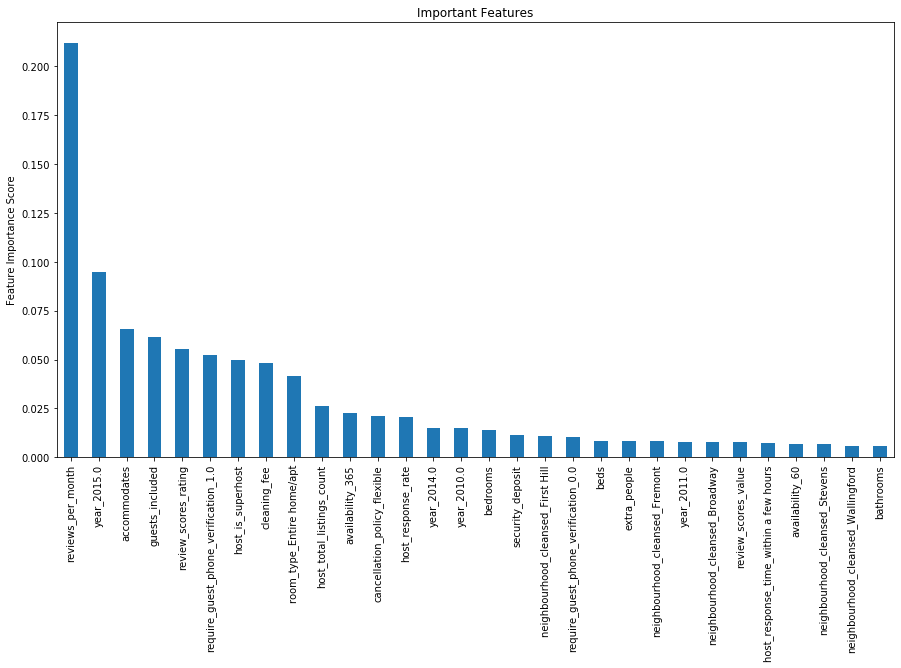

In [230]:
#### find important variables, confusion matrix for benchmark model
baseline = GradientBoostingClassifier(random_state=10)
baseline.fit(X_train,Y_train)
predictors=list(X_train)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False).head(30)

# show the important features from highest to lowest 
feat_imp.plot(kind='bar', title='Important Features', figsize=(15,8))
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on train set: {:.3f}'.format(baseline.score(X_train, Y_train)))
print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(X_test, Y_test)))
pred = baseline.predict(X_test)
print("Classification report for test set:")
print(classification_report(Y_test, pred))
print("Confusion Matrix for test set:")
print(confusion_matrix(Y_test, pred))

In [232]:
#### lets tune the GB model and find the best parameters :  learning rate and number of trees

p_test = {'learning_rate':[0.25,0.2,0.15,0.1,0.05,0.01,0.005,0.001] ,'n_estimators':[10,20,50, 100, 150,200,250]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_features='sqrt', random_state=10), 
            param_grid = p_test, scoring='accuracy',n_jobs=-1, cv=10)

tuning.fit(X_train,Y_train)

# find the mean and stdev of cross validated datasets
means = tuning.cv_results_['mean_test_score']
stds = tuning.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, tuning.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

tuning.best_score_ , tuning.best_params_   

0.833 (+/-0.020) for {'learning_rate': 0.25, 'n_estimators': 10}
0.837 (+/-0.019) for {'learning_rate': 0.25, 'n_estimators': 20}
0.847 (+/-0.023) for {'learning_rate': 0.25, 'n_estimators': 50}
0.855 (+/-0.026) for {'learning_rate': 0.25, 'n_estimators': 100}
0.856 (+/-0.025) for {'learning_rate': 0.25, 'n_estimators': 150}
0.860 (+/-0.033) for {'learning_rate': 0.25, 'n_estimators': 200}
0.858 (+/-0.041) for {'learning_rate': 0.25, 'n_estimators': 250}
0.832 (+/-0.017) for {'learning_rate': 0.2, 'n_estimators': 10}
0.840 (+/-0.023) for {'learning_rate': 0.2, 'n_estimators': 20}
0.848 (+/-0.020) for {'learning_rate': 0.2, 'n_estimators': 50}
0.856 (+/-0.039) for {'learning_rate': 0.2, 'n_estimators': 100}
0.856 (+/-0.034) for {'learning_rate': 0.2, 'n_estimators': 150}
0.856 (+/-0.033) for {'learning_rate': 0.2, 'n_estimators': 200}
0.855 (+/-0.034) for {'learning_rate': 0.2, 'n_estimators': 250}
0.829 (+/-0.009) for {'learning_rate': 0.15, 'n_estimators': 10}
0.834 (+/-0.017) for {'l

(0.859663191659984, {'learning_rate': 0.25, 'n_estimators': 200})

Accuracy of the GBM on train set: 0.984
Accuracy of the GBM on test set: 0.867
Classification report for test set:
              precision    recall  f1-score   support

         Low       0.92      0.93      0.92       520
         Top       0.61      0.58      0.59       104

    accuracy                           0.87       624
   macro avg       0.76      0.75      0.76       624
weighted avg       0.86      0.87      0.87       624

Confusion Matrix for test set:
[[481  39]
 [ 44  60]]


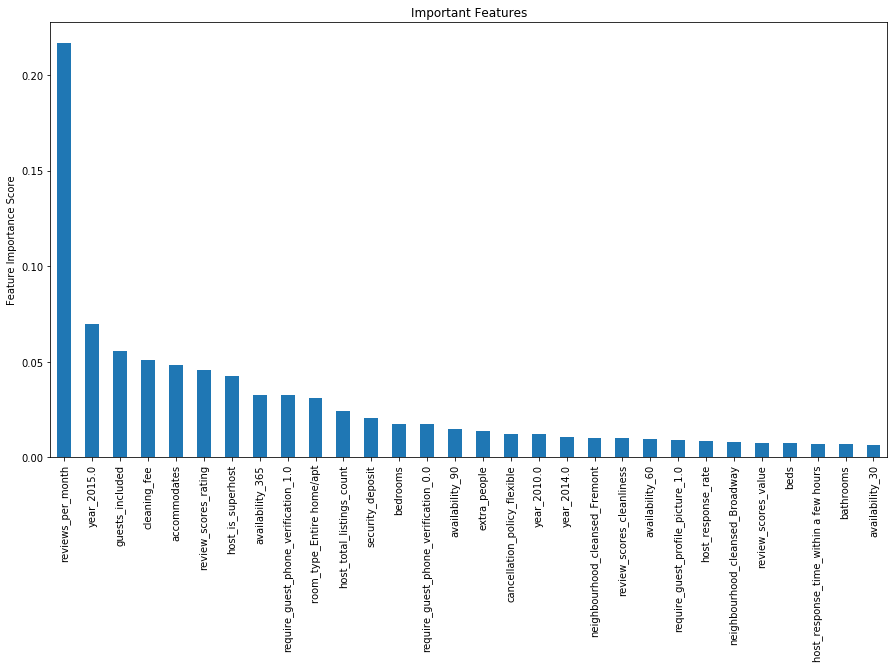

In [320]:
## fit the best model on train and find the accuracy for test data
best_model = GradientBoostingClassifier(learning_rate=0.25, n_estimators=200, random_state=10)
best_model.fit(X_train,Y_train)

predictors=list(X_train)
feat_imp = pd.Series(best_model.feature_importances_, predictors).sort_values(ascending=False).head(30)

# show the important features of the best fitted model sorted from highest to lowest 
feat_imp.plot(kind='bar', title='Important Features', figsize=(15,8))
plt.ylabel('Feature Importance Score')

print('Accuracy of the GBM on train set: {:.3f}'.format(best_model.score(X_train, Y_train)))
print('Accuracy of the GBM on test set: {:.3f}'.format(best_model.score(X_test, Y_test)))
pred = best_model.predict(X_test)
print("Classification report for test set:")
print(classification_report(Y_test, pred))
print("Confusion Matrix for test set:")
print(confusion_matrix(Y_test, pred))

In [235]:
# lets see how other classification algorithms perform 
# as it is shown in the output, Gradient Boosted Classifier has the highest accuracy and there is no need to 
# benchmark other algorithms.

classifiers = {
    "LogisiticRegression": LogisticRegression(solver='liblinear'),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(gamma ='auto'),
    "DecisionTreeClassifier": GradientBoostingClassifier()
}

In [236]:
## print the accuracy for all
for key, classifier in classifiers.items():
    classifier.fit(X_train, Y_train)
    training_score = cross_val_score(classifier, X_train, Y_train, cv=10)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 84.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 82.0 % accuracy score
Classifiers:  SVC Has a training score of 82.0 % accuracy score
Classifiers:  GradientBoostingClassifier Has a training score of 85.0 % accuracy score


In [237]:
### use imblearn package to deal with imbalanced data
# this function visualize how the train data is ditributed by a 2 dimensional plot

def plot_2d_space(X, y, label='Performance'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

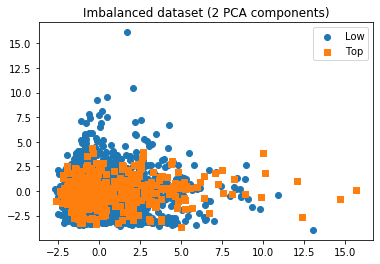

In [238]:
## project X_train in two dimension for better visualization and see how top and low performers distributed
# number of components
pca = PCA(n_components=2)
# transform the train data
X = pca.fit_transform(X_train)

plot_2d_space(X, Y_train, 'Imbalanced dataset (2 PCA components)')

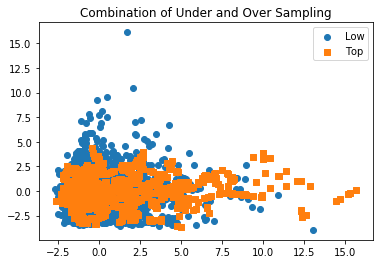

In [242]:
# use SMOTE technique to resample(over sample or under sample) to deal with imbalanced performance class
# automatically under or over sample
sm = SMOTETomek(ratio='auto')
X_com, y_com = smt.fit_sample(X, Y_train)
# show the plot
plot_2d_space(X_com, y_com, 'Combination of Under and Over Sampling')

In [323]:
# show number of top and low repeated in train data set before sampling and after sampling
# before top and low counts
print("Before OverSampling, count of 'Top': {}".format(sum(Y_train== "Top")))
print("Before OverSampling, count of 'Low': {} \n".format(sum(Y_train== "Low")))

X_train_reshape, Y_train_reshape = sm.fit_sample(X_train, Y_train.ravel())

# in total 4108 records and half gonna be top and the other half low after resampling
print('After ReSampling, the shape of X_train: {}'.format(X_train_reshape.shape))
print('After ReSampling, the shape of Y_train: {} \n'.format(Y_train_reshape.shape))

# after Resampling
print("After ReSampling, count of 'Top': {}".format(sum(Y_train_reshape== "Top")))
print("After ReSampling, count of 'Low': {}".format(sum(Y_train_reshape== "Low")))

Before OverSampling, count of 'Top': 440
Before OverSampling, count of 'Low': 2054 

After ReSampling, the shape of X_train: (4108, 156)
After ReSampling, the shape of Y_train: (4108,) 

After ReSampling, count of 'Top': 2054
After ReSampling, count of 'Low': 2054


In [244]:
## which classifier performs better on resampled data
classifiers = {
    "LogisiticRegression": LogisticRegression(solver='liblinear'),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(gamma ='auto'),
    "DecisionTreeClassifier": GradientBoostingClassifier()
}

## print the accuracy for all
for key, classifier in classifiers.items():
    classifier.fit(X_train_reshape, Y_train_reshape)
    training_score = cross_val_score(classifier, X_train_reshape, Y_train_reshape, cv=10)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")
## still GBM performes the best on reshaped data    

Classifiers:  LogisticRegression Has a training score of 82.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 80.0 % accuracy score
Classifiers:  SVC Has a training score of 84.0 % accuracy score
Classifiers:  GradientBoostingClassifier Has a training score of 91.0 % accuracy score


In [245]:
#### best GBM parameters in predicting reshaped train data

p_test = {'learning_rate':[0.25,0.2,0.15,0.1,0.05,0.01,0.005,0.001] ,'n_estimators':[10,20,50, 100, 150,200,250]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_features='sqrt', random_state=10), 
            param_grid = p_test, scoring='accuracy',n_jobs=-1, cv=10)

tuning.fit(X_train_reshape,Y_train_reshape.ravel())
means = tuning.cv_results_['mean_test_score']
stds = tuning.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, tuning.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
# return the best parameters and highest accuracy    
tuning.best_score_ , tuning.best_params_   

0.850 (+/-0.117) for {'learning_rate': 0.25, 'n_estimators': 10}
0.873 (+/-0.134) for {'learning_rate': 0.25, 'n_estimators': 20}
0.899 (+/-0.152) for {'learning_rate': 0.25, 'n_estimators': 50}
0.907 (+/-0.169) for {'learning_rate': 0.25, 'n_estimators': 100}
0.906 (+/-0.182) for {'learning_rate': 0.25, 'n_estimators': 150}
0.908 (+/-0.182) for {'learning_rate': 0.25, 'n_estimators': 200}
0.908 (+/-0.184) for {'learning_rate': 0.25, 'n_estimators': 250}
0.848 (+/-0.123) for {'learning_rate': 0.2, 'n_estimators': 10}
0.869 (+/-0.140) for {'learning_rate': 0.2, 'n_estimators': 20}
0.891 (+/-0.171) for {'learning_rate': 0.2, 'n_estimators': 50}
0.907 (+/-0.175) for {'learning_rate': 0.2, 'n_estimators': 100}
0.909 (+/-0.180) for {'learning_rate': 0.2, 'n_estimators': 150}
0.913 (+/-0.181) for {'learning_rate': 0.2, 'n_estimators': 200}
0.911 (+/-0.186) for {'learning_rate': 0.2, 'n_estimators': 250}
0.837 (+/-0.110) for {'learning_rate': 0.15, 'n_estimators': 10}
0.862 (+/-0.131) for {'l

(0.9128105211885046, {'learning_rate': 0.2, 'n_estimators': 200})

In [254]:
## refit the best model and find the accuracy for test data 
best_model_oversample = GradientBoostingClassifier(learning_rate=0.2, n_estimators=200, random_state=10)
best_model_oversample.fit(X_train_reshape,Y_train_reshape)

predictors=list(X_train_reshape)
# print train accuracy 
print('Accuracy of the GBM on train set: {:.3f}'.format(best_model_oversample.score(X_train, Y_train)))
pred = best_model_oversample.predict(X_train)
print(classification_report(Y_train, pred))
# train confusion matrix
print("Confusion Matrix for train set:")
print(confusion_matrix(Y_train, pred))

Accuracy of the GBM on train set: 0.966
              precision    recall  f1-score   support

         Low       0.97      0.98      0.98      2054
         Top       0.92      0.88      0.90       440

    accuracy                           0.97      2494
   macro avg       0.95      0.93      0.94      2494
weighted avg       0.97      0.97      0.97      2494

Confusion Matrix for train set:
[[2020   34]
 [  52  388]]


In [255]:
## print the confusion matrix and the accuracy for test data 
print('Accuracy of the GBM on test set: {:.3f}'.format(best_model_oversample.score(X_test, Y_test)))
pred = best_model_oversample.predict(X_test)
print(classification_report(Y_test, pred))
print("Confusion Matrix for test set:")
print(confusion_matrix(Y_test, pred))

Accuracy of the GBM on test set: 0.854
              precision    recall  f1-score   support

         Low       0.93      0.90      0.91       520
         Top       0.55      0.64      0.60       104

    accuracy                           0.85       624
   macro avg       0.74      0.77      0.75       624
weighted avg       0.86      0.85      0.86       624

Confusion Matrix for test set:
[[466  54]
 [ 37  67]]


In [324]:
# this function plots a nice confusion matrix
# the input for this fuction in confusion matrix generated by cofusion_matrix and actual, predicted classes 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# find predicted values on train set
#y_train_predicted = best_model_oversample.predict(X_train)
# confusion matrix for train 
#c_matrix = confusion_matrix(Y_train, y_train_predicted)

# print the recall 
# print("Recall metric in the test dataset: {}%".format(100*c_matrix[1,1]/(c_matrix[1,0]+c_matrix[1,1])))
# name of the classes 
# class_names = ["Low","Top"]
#plt.figure()
#confusion_matrix(c_matrix , classes=class_names, title='Train Confusion matrix')
#plt.show()

Recall metric in the testing dataset: 64.42307692307692%


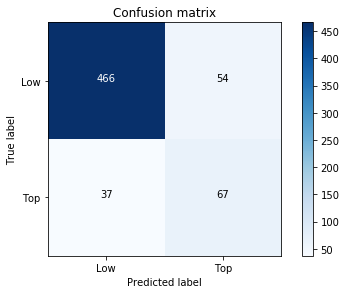

In [250]:
# predicted values on test set
y_predicted = best_model_oversample.predict(X_test)
# calculate confusion matrix
c_matrix = confusion_matrix(Y_test, y_predicted)
# calculate recall
print("Recall metric in the testing dataset: {}%".format(100*c_matrix[1,1]/(c_matrix[1,0]+c_matrix[1,1])))

# labels of 2 classes
class_names = ["Low","Top"]
plt.figure()
plot_confusion_matrix(c_matrix , classes=class_names, title='Confusion matrix')
plt.show()

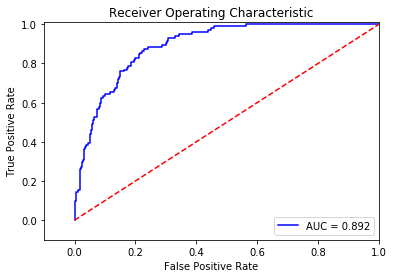

In [270]:
# plot ROC curve for reshaped data
tmp = best_model_oversample.fit(X_train_reshape, Y_train_reshape.ravel())
y_pred_sample_score = tmp.decision_function(X_test)
# calculate false positive and true positive 
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_sample_score , pos_label='Top')
# find accuracy
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Imbalanced AUC: 0.900
Balanced AUC: 0.892


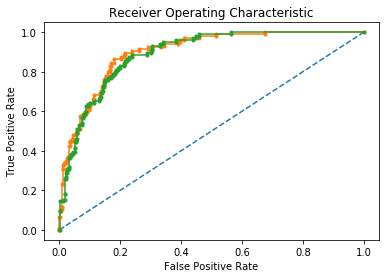

In [316]:
#### comparing the ROC curve of best model on inbalanced and balanced data
## Imbalanced model
# predict probabilities
probs_1 = best_model.predict_proba(X_test)
# keep positive probabilities 
probs_1 = probs_1[:, 1]
# calculate accuracy
auc_1 = roc_auc_score(Y_test, probs_1)
print('Imbalanced AUC: %.3f' % auc_1)
# calculate roc curve for imbalanced data
fpr_1, tpr_1, thresholds_1 = roc_curve(Y_test, probs_1, pos_label='Top')

## Balanced data
# predict probabilities
probs_2 = best_model_oversample.predict_proba(X_test)
# keep positive probabilities 
probs_2 = probs_2[:, 1]
# calculate auc, accuracy
auc_2 = roc_auc_score(Y_test, probs_2)
print('Balanced AUC: %.3f' % auc_2)
# calculate roc curve for Balanced data
fpr_2, tpr_2, thresholds_2 = roc_curve(Y_test, probs_2, pos_label='Top')

# add the title
plt.title('Receiver Operating Characteristic')

# plot 
pyplot.plot([0, 1], [0, 1], linestyle='--')
# add imbalanced values to the plot
pyplot.plot(fpr_1, tpr_1, marker='.') 
# add balanced values to plot
pyplot.plot(fpr_2, tpr_2, marker='.')

# name the axis
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# show the plot
pyplot.show()

Imbalanced f1=0.591 AUC=0.645 MAP=0.648
Balanced f1=0.596 AUC=0.900 MAP=0.597


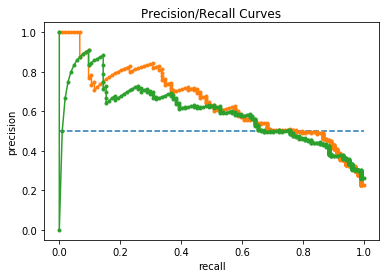

In [319]:
#### comparing the Precision and Recall curve of best model on inbalanced and balanced data
### Imbalanced data
# predict probabilities for Imbalanced data
probs = best_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = best_model.predict(X_test)
# calculate precision-recall curve: positive class is top 
precision, recall, thresholds = precision_recall_curve(Y_test, probs, pos_label='Top')
# calculate F1 score
f1 = f1_score(Y_test, yhat, average="binary", pos_label="Top")
# calculate precision-recall area under curve 
auc = auc(recall, precision)
# calculate average precision score (MAP)
ap = average_precision_score(Y_test, probs, pos_label="Top")

## Balanced data
# predict probability
probs_1 = best_model_oversample.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs_1 = probs_1[:, 1]
# predict class values
yhat_1 = best_model_oversample.predict(X_test)
# calculate precision-recall curve
precision_1, recall_1, thresholds_1 = precision_recall_curve(Y_test, probs_1, pos_label='Top')
# calculate F1 score
f1_1 = f1_score(Y_test, yhat_1, average="binary", pos_label="Top")
# calculate precision-recall AUC
auc_1 = auc(recall_1, precision_1)
# calculate average precision score
ap_1 = average_precision_score(Y_test, probs_1, pos_label="Top")

# print Area Under Curve, F1 scores and Mean Average Precision for both models
print('Imbalanced f1=%.3f AUC=%.3f MAP=%.3f' % (f1, auc, ap))
print('Balanced f1=%.3f AUC=%.3f MAP=%.3f' % (f1_1, auc_1, ap_1))
# add title
plt.title('Precision/Recall Curves')
# plot
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
pyplot.plot(recall_1, precision_1, marker='.')

# add label
pyplot.ylabel('precision')
pyplot.xlabel('recall')
# show the plot
pyplot.show()